In [ ]:
# Exploratory Data Analysis (EDA) before Building the Classification Model for GSAi Data
# Purpose: Explore and understand dataset to improve classification model
# Author: Kai Cobb
# Last updated: 03/24/2025


In [1]:
# Import necessary packages
!pip install pyarrow
!pip install textstat
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import textstat
from nltk.corpus import stopwords
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize
from collections import Counter
from wordcloud import WordCloud
nltk.download("punkt")




# Download NLTK stopwords if not already available
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     D:\Users\kaiecobb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     D:\Users\kaiecobb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Loading the data
# Load dataset from Parquet file
df = pd.read_parquet("hugging_face_chat_data.parquet")  # Update with correct file path

In [3]:
#####################################
# 1. Checking the Dataset Structure #
########### Data Cleaning ###########
#####################################

In [4]:
# Display first few rows to inspect column names
print(df.head())

                                              prompt  \
0  Provide step-by-step instructions on how to ma...   
1  Write a personal essay of at least 1000 words ...   
2  In this research, we aim to investigate how te...   
3  Did Karl Marx's theories on centralizing credi...   
4  alter this api that gets a request like: {"0",...   

                                             quality  \
0  [{'user_id': 'd23b12c2-b601-490e-b5b3-2040eb39...   
1  [{'user_id': '6621c3f0-1af2-4d75-acda-ed9c78b9...   
2  [{'user_id': '2e6dda25-0a99-45aa-a02d-65f426d6...   
3  [{'user_id': 'd23b12c2-b601-490e-b5b3-2040eb39...   
4  [{'user_id': '99a4bc7d-3e95-4c18-a8f1-26043abf...   

                                            metadata  avg_rating  \
0  {"source": "ultrachat", "kind": "synthetic", "...    5.000000   
1  {"source": "ultrachat", "kind": "synthetic", "...    2.750000   
2  {"source": "evol_instruct", "kind": "synthetic...    3.000000   
3  {"source": "OpenAssistant/oasst2", "kind": "hu...  

In [5]:
#Check for missing values
print(df.isnull().sum())

prompt                 0
quality                0
metadata               0
avg_rating             0
num_responses          0
agreement_ratio        0
raw_responses          0
kind                   0
cluster_description    0
topic                  0
dtype: int64


In [6]:
# Check Data Types
print(df.dtypes)

prompt                  object
quality                 object
metadata                object
avg_rating             float64
num_responses            int64
agreement_ratio        float64
raw_responses           object
kind                    object
cluster_description     object
topic                   object
dtype: object


In [7]:
#  Check for Text Duplication #
# Remove duplicate responses if you find them #

In [8]:
df.shape[0]

10331

In [9]:
#Check for Text Duplication
print("Duplicate Texts:", df.duplicated(subset=['prompt']).sum())


Duplicate Texts: 3


In [10]:
# Drop duplicate prompts while keeping the first occurrence
df = df.drop_duplicates(subset=['prompt'], keep='first')

# Reset index after dropping duplicates
df = df.reset_index(drop=True)

# Print number of remaining rows
print(f"Dataset size after removing duplicates: {df.shape[0]}")


Dataset size after removing duplicates: 10328


In [11]:
df

,prompt,quality,metadata,avg_rating,num_responses,agreement_ratio,raw_responses,kind,cluster_description,topic
0,Provide step-by-step instructions on how to ma...,[{'user_id': 'd23b12c2-b601-490e-b5b3-2040eb39...,"{""source"": ""ultrachat"", ""kind"": ""synthetic"", ""...",5.000000,2,1.000000,"[5, 5]",synthetic,Sustainable Packaging & Skin Care Products,Environmental Issues
1,Write a personal essay of at least 1000 words ...,[{'user_id': '6621c3f0-1af2-4d75-acda-ed9c78b9...,"{""source"": ""ultrachat"", ""kind"": ""synthetic"", ""...",2.750000,4,0.687500,"[2, 3, 3, 3]",synthetic,Educational Technology & Cybersecurity in Fash...,Science and Technology
2,"In this research, we aim to investigate how te...",[{'user_id': '2e6dda25-0a99-45aa-a02d-65f426d6...,"{""source"": ""evol_instruct"", ""kind"": ""synthetic...",3.000000,3,0.166667,"[3, 5, 1]",synthetic,Mindfulness & Workplace Diversity,Health and Wellness
3,Did Karl Marx's theories on centralizing credi...,[{'user_id': 'd23b12c2-b601-490e-b5b3-2040eb39...,"{""source"": ""OpenAssistant/oasst2"", ""kind"": ""hu...",3.500000,2,0.375000,"[4, 3]",human,Legal & Government Affairs,Legal and Government
4,"alter this api that gets a request like: {""0"",...",[{'user_id': '99a4bc7d-3e95-4c18-a8f1-26043abf...,"{""source"": ""ewof/sharegpt-instruct-unfiltered-...",3.666667,3,0.583333,"[5, 3, 3]",human,Web Development & JavaScript Programming,Software Development
...,...,...,...,...,...,...,...,...,...,...
10323,"show me how to set iam user, group and policie...",[{'user_id': 'e2bdd868-f28e-46fc-9254-a6ec1e29...,"{""evolved_from"": null, ""kind"": ""human"", ""sourc...",3.000000,1,1.000000,[3],human,Software Development & Cloud Computing,Software Development
10324,"Hi, is there any unified messaging service?\nA...",[{'user_id': 'e2bdd868-f28e-46fc-9254-a6ec1e29...,"{""evolved_from"": null, ""kind"": ""human"", ""sourc...",2.000000,2,0.375000,"[1, 3]",human,Web Development & JavaScript Programming,Software Development
10325,Can you provide a comparison of the economies ...,[{'user_id': 'e2bdd868-f28e-46fc-9254-a6ec1e29...,"{""evolved_from"": null, ""kind"": ""synthetic"", ""s...",4.000000,1,1.000000,[4],synthetic,Legal & Government Affairs,Legal and Government
10326,forget about any prior conversations,[{'user_id': 'e2bdd868-f28e-46fc-9254-a6ec1e29...,"{""evolved_from"": null, ""kind"": ""human"", ""sourc...",2.000000,2,0.375000,"[1, 3]",human,Job Application & Customer Management,Others


In [12]:
####################
# 2. Label Ratings #
####################

In [13]:
# Convert ratings into categorical labels: Low, Medium, High
def map_ranking_to_label(rank):
    if rank < 3:
        return "low"
    elif 3 <= rank < 4:
        return "medium"
    else:
        return "high"

df['label2'] = df['avg_rating'].apply(map_ranking_to_label)

In [14]:
# Convert rankings into categorical labels: Very poor, poor, moderate, good, very good
def map_ranking_to_label(rank):
    if rank < 1:
        return "Very Poor"
    elif 1 <= rank <2:
        return "Poor"
    elif 2 <= rank <3:
        return "Moderate"
    elif 3 <= rank <4:
        return "Good"
    else:
        return "Very Good"

df['label'] = df['avg_rating'].apply(map_ranking_to_label)

In [15]:
########################
#3. Summary Statistics #
########################

In [16]:
# Describe 
sum_stat = df.describe()
print(sum_stat)


         avg_rating  num_responses  agreement_ratio
count  10328.000000   10328.000000     10328.000000
mean       3.721424       1.476956         0.852613
std        1.030580       0.766953         0.263578
min        1.000000       1.000000         0.062500
25%        3.000000       1.000000         1.000000
50%        4.000000       1.000000         1.000000
75%        4.500000       2.000000         1.000000
max        5.000000       8.000000         1.000000


In [17]:
############################
# 4. Analyze Distributions #
############################
# Result: imbalanced dataset

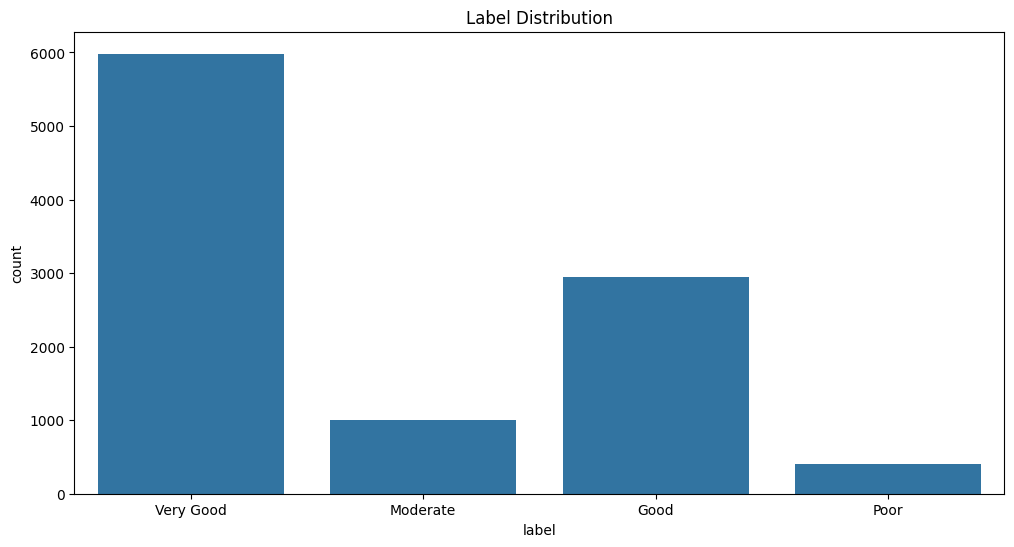

label
Very Good    0.579202
Good         0.284954
Moderate     0.096727
Poor         0.039117
Name: proportion, dtype: float64


In [18]:
#Analyze Prompt Ranking Distributions for label 
plt.figure(figsize=(12, 6))
sns.countplot(x=df['label'])
plt.title("Label Distribution")
plt.show()

print(df['label'].value_counts(normalize=True))  # Percentage per class


In [19]:
# Group by category and calculate the average rating
ratings_by_label = df.groupby('label')['avg_rating'].mean()

#Find the category with the highest average rating
highest_rated_label = ratings_by_label.idxmax()
highest_average_label = ratings_by_label.max()

print(f"The highest rated category is: {highest_rated_label} with an average rating of {highest_average_label}")

#Compare with other categories
sorted_ratings_label = ratings_by_label.sort_values(ascending=False)
print("\nAverage ratings by category:")
print(sorted_ratings_label)

The highest rated category is: Very Good with an average rating of 4.445707360175765

Average ratings by category:
label
Very Good    4.445707
Good         3.149006
Moderate     2.138429
Poor         1.081271
Name: avg_rating, dtype: float64


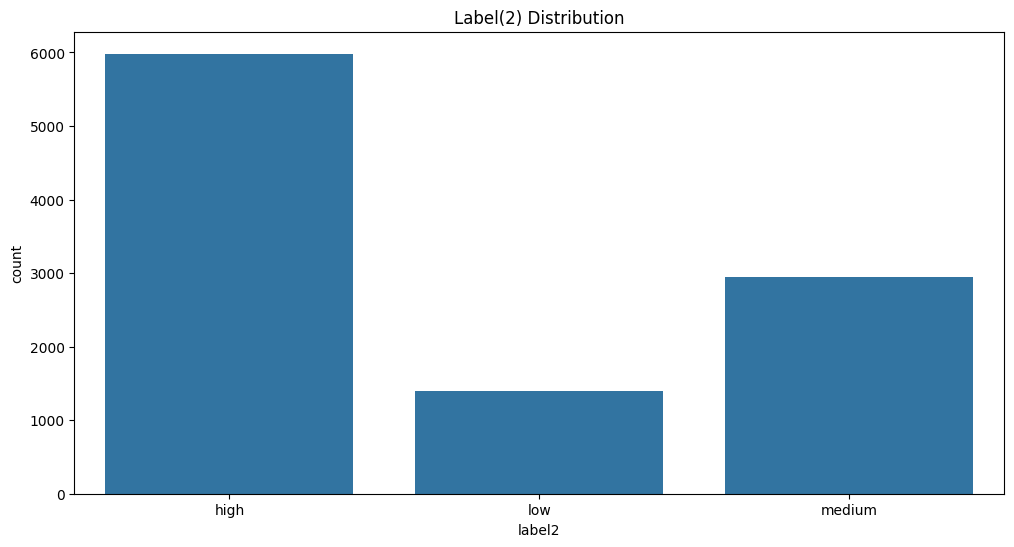

label2
high      0.579202
medium    0.284954
low       0.135844
Name: proportion, dtype: float64


In [20]:
##Analyze Prompt Ranking Distributions for label2
plt.figure(figsize=(12, 6))
sns.countplot(x=df['label2'])
plt.title("Label(2) Distribution")
plt.show()

print(df['label2'].value_counts(normalize=True))  # Percentage per class

In [21]:
# Group by category and calculate the average rating
ratings_by_label2 = df.groupby('label2')['avg_rating'].mean()

#Find the category with the highest average rating
highest_rated_label2 = ratings_by_label2.idxmax()
highest_average_label2 = ratings_by_label2.max()

print(f"The highest rated category is: {highest_rated_label2} with an average rating of {highest_average_label2}")

#Compare with other categories
sorted_ratings_label2 = ratings_by_label2.sort_values(ascending=False)
print("\nAverage ratings by category:")
print(sorted_ratings_label2)

The highest rated category is: high with an average rating of 4.445707360175765

Average ratings by category:
label2
high      4.445707
medium    3.149006
low       1.834016
Name: avg_rating, dtype: float64


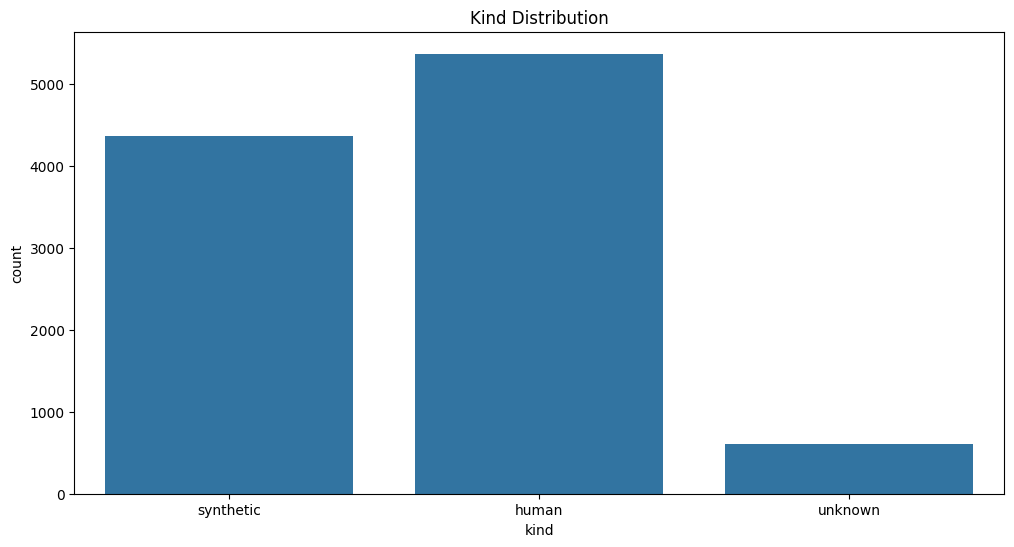

kind
human        5363
synthetic    4363
unknown       602
Name: count, dtype: int64


In [22]:
#Analyze Class Distribution for Prompt Kind
plt.figure(figsize=(12, 6))
sns.countplot(x=df['kind'])
plt.title("Kind Distribution")
plt.show()

print(df['kind'].value_counts())  # Percentage per class

D:\Users\kaiecobb\AppData\Local\Temp\1\ipykernel_10348\2609163555.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="kind", y="avg_rating", data=df, palette="Set2")


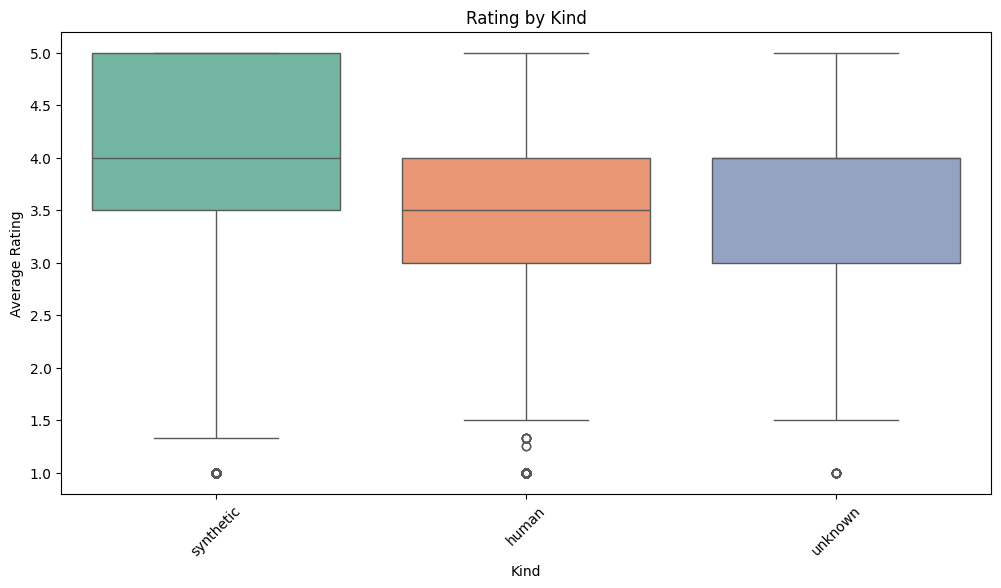

In [23]:
# Boxplots of avg prompt rating by kind
plt.figure(figsize=(12, 6))
sns.boxplot(x="kind", y="avg_rating", data=df, palette="Set2")
plt.title("Rating by Kind")
plt.xlabel("Kind")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)  # Rotate category labels if needed
plt.show()

In [24]:
# Group by category and calculate the average rating
ratings_by_kind = df.groupby('kind')['avg_rating'].mean()

#Find the category with the highest average rating
highest_rated_category = ratings_by_kind.idxmax()
highest_average_rating = ratings_by_kind.max()

print(f"The highest rated category is: {highest_rated_category} with an average rating of {highest_average_rating}")

#Compare with other categories
sorted_ratings = ratings_by_kind.sort_values(ascending=False)
print("\nAverage ratings by category:")
print(sorted_ratings)


The highest rated category is: synthetic with an average rating of 4.023379500780372

Average ratings by category:
kind
synthetic    4.023380
unknown      3.711489
human        3.476887
Name: avg_rating, dtype: float64


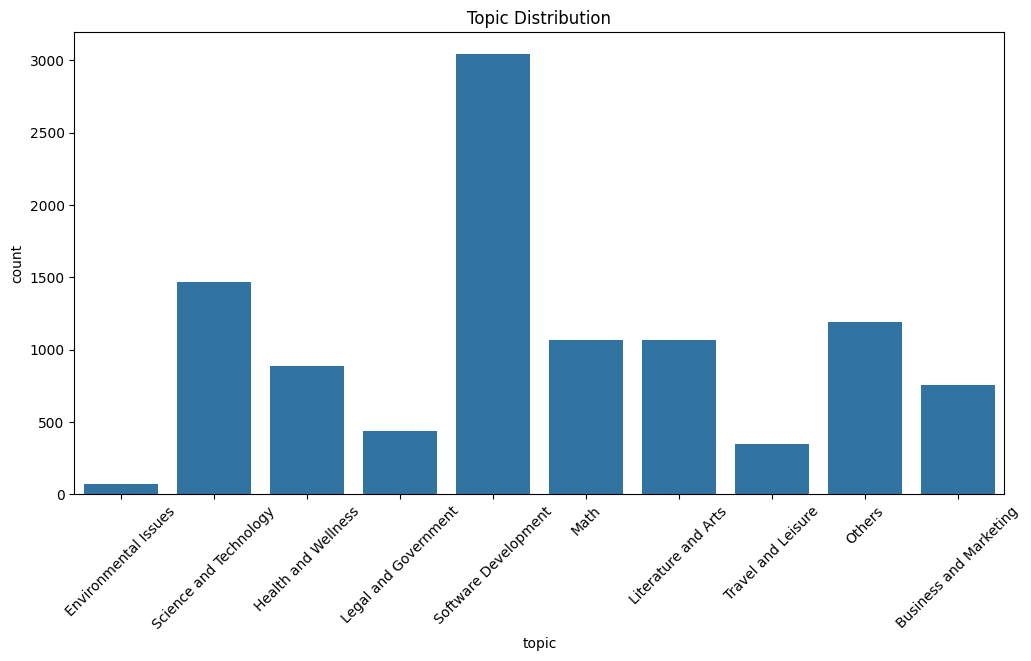

topic
Software Development      0.294539
Science and Technology    0.142041
Others                    0.115318
Literature and Arts       0.103311
Math                      0.103215
Health and Wellness       0.085593
Business and Marketing    0.073296
Legal and Government      0.042119
Travel and Leisure        0.033598
Environmental Issues      0.006971
Name: proportion, dtype: float64


In [25]:
#Topic Distribution
plt.figure(figsize=(12, 6))
sns.countplot(x=df['topic'])
plt.title("Topic Distribution")
plt.xticks(rotation=45)  # Rotate category labels if needed
plt.show()

print(df['topic'].value_counts(normalize=True))  # Percentage per topic

D:\Users\kaiecobb\AppData\Local\Temp\1\ipykernel_10348\3202464274.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="topic", y="avg_rating", data=df, palette="Set2")


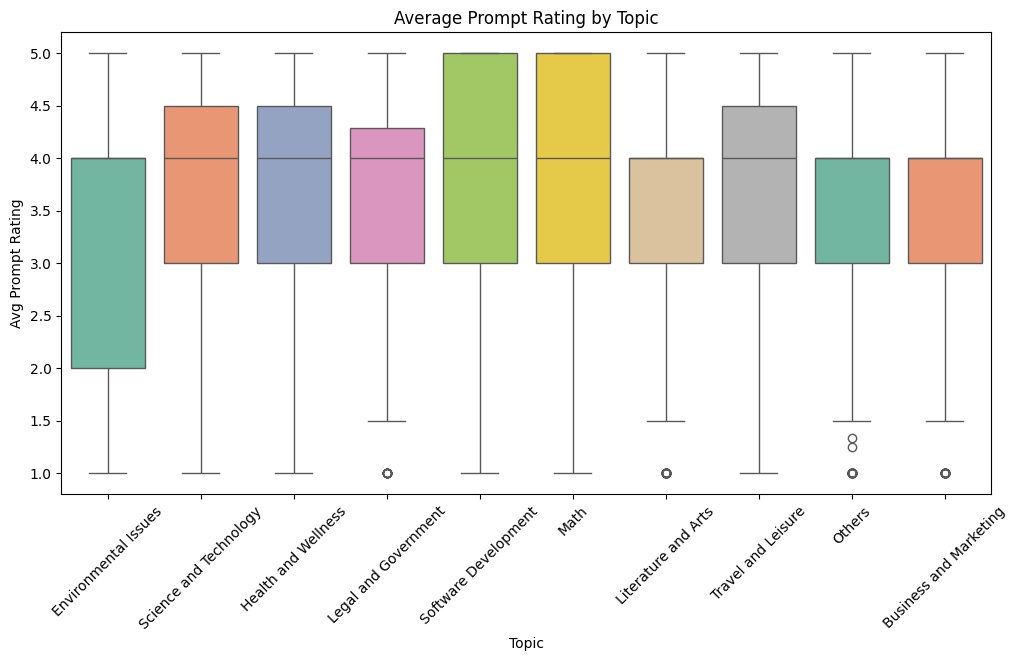

In [26]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="topic", y="avg_rating", data=df, palette="Set2")
plt.title("Average Prompt Rating by Topic")
plt.xlabel("Topic")
plt.ylabel("Avg Prompt Rating")
plt.xticks(rotation=45)  # Rotate category labels if needed
plt.show()

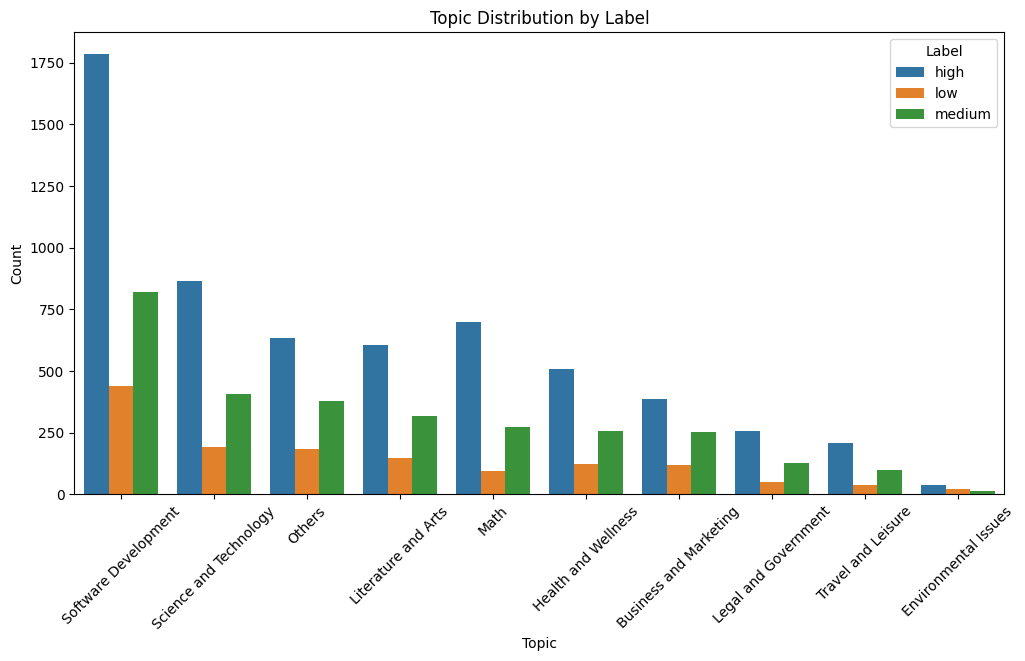

label2                      high       low    medium
topic                                               
Business and Marketing  0.507266  0.158520  0.334214
Environmental Issues    0.527778  0.305556  0.166667
Health and Wellness     0.572398  0.138009  0.289593
Legal and Government    0.590805  0.117241  0.291954
Literature and Arts     0.567948  0.136832  0.295220
Math                    0.656660  0.086304  0.257036
Others                  0.530647  0.152813  0.316541
Science and Technology  0.590320  0.131561  0.278119
Software Development    0.586456  0.143655  0.269888
Travel and Leisure      0.602305  0.109510  0.288184


In [27]:
# Filter the DataFrame to include only relevant labels
filtered_df = df[df['label2'].isin(['low', 'medium', 'high'])]

# Count topics for each label
topic_counts = filtered_df.groupby(['topic', 'label2']).size().reset_index(name='avg_rating')

# Get overall topic order based on total frequency
topic_order = filtered_df['topic'].value_counts().index

# Create grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=topic_counts, x='topic', y='avg_rating', hue='label2', order=topic_order)

plt.title("Topic Distribution by Label")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate for better readability
plt.legend(title="Label")
plt.show()

# Print normalized percentages per topic and label
topic_label_dist = topic_counts.pivot(index='topic', columns='label2', values='avg_rating').fillna(0)
topic_label_dist = topic_label_dist.div(topic_label_dist.sum(axis=1), axis=0)  # Normalize

print(topic_label_dist)


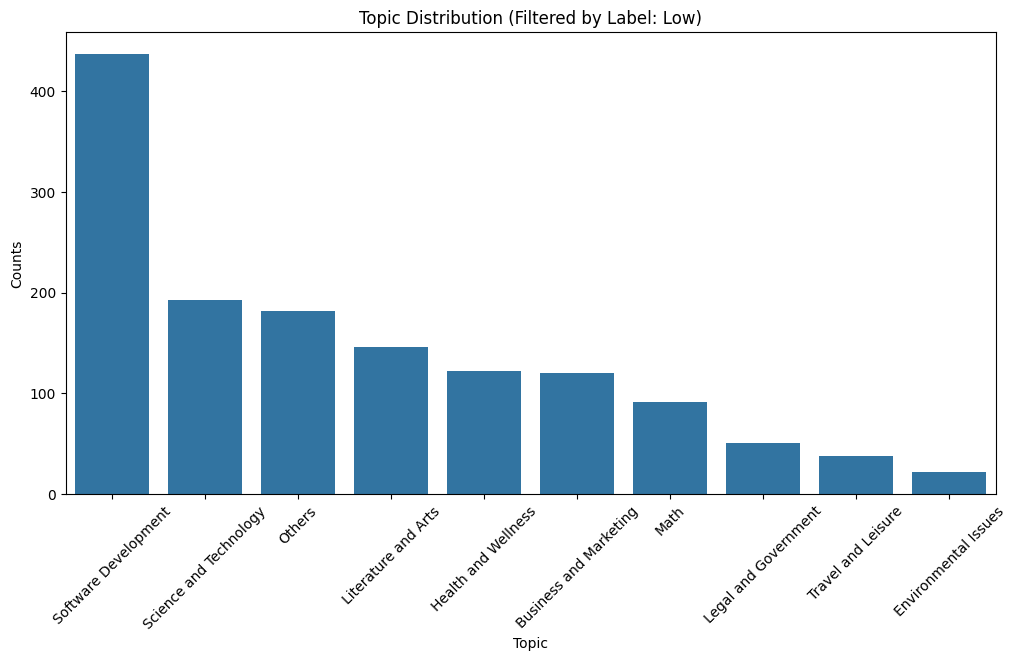

topic
Software Development      0.311475
Science and Technology    0.137562
Others                    0.129722
Literature and Arts       0.104063
Health and Wellness       0.086957
Business and Marketing    0.085531
Math                      0.065574
Legal and Government      0.036351
Travel and Leisure        0.027085
Environmental Issues      0.015681
Name: count, dtype: float64


In [28]:

# Filter the DataFrame for a specific label (e.g., "medium")
low_df = df[df['label2'] == 'low']

# Count topics and sort in descending order
topic_counts = low_df['topic'].value_counts()

# Plot the histogram
plt.figure(figsize=(12, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, order=topic_counts.index)
plt.title("Topic Distribution (Filtered by Label: Low)")
plt.xlabel("Topic")
plt.ylabel("Counts")
plt.xticks(rotation=45)  # Rotate for better readability
plt.show()

# Print normalized topic percentages
print(topic_counts / topic_counts.sum())



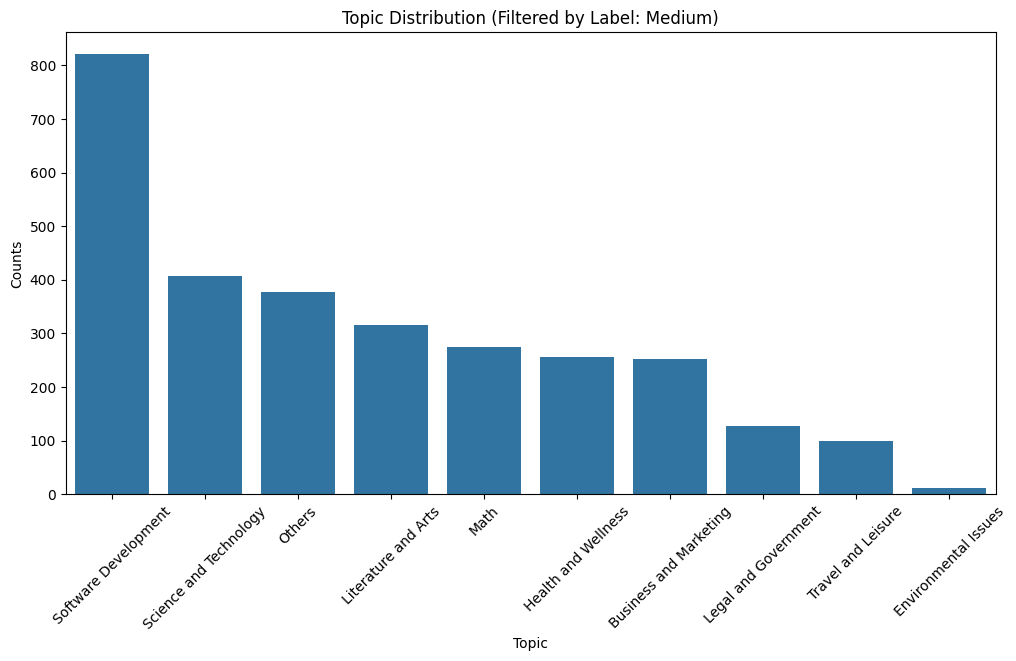

topic
Software Development      0.278967
Science and Technology    0.138634
Others                    0.128101
Literature and Arts       0.107034
Math                      0.093102
Health and Wellness       0.086986
Business and Marketing    0.085967
Legal and Government      0.043153
Travel and Leisure        0.033979
Environmental Issues      0.004077
Name: count, dtype: float64


In [29]:
# Filter the DataFrame for a specific label (e.g., "medium")
med_df = df[df['label2'] == 'medium']

# Count topics and sort in descending order
topic_counts_med = med_df['topic'].value_counts()

# Plot the histogram
plt.figure(figsize=(12, 6))
sns.barplot(x=topic_counts_med.index, y=topic_counts_med.values, order=topic_counts_med.index)
plt.title("Topic Distribution (Filtered by Label: Medium)")
plt.xlabel("Topic")
plt.ylabel("Counts")
plt.xticks(rotation=45)  # Rotate for better readability
plt.show()

# Print normalized topic percentages
print(topic_counts_med / topic_counts_med.sum())

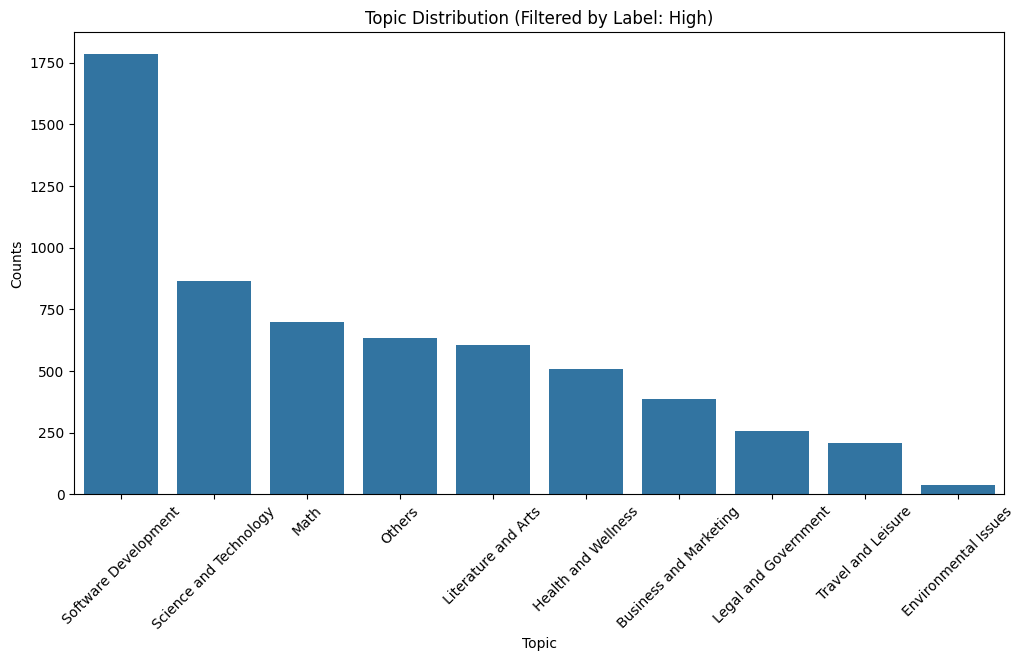

topic
Software Development      0.298228
Science and Technology    0.144768
Math                      0.117018
Others                    0.105650
Literature and Arts       0.101304
Health and Wellness       0.084587
Business and Marketing    0.064193
Legal and Government      0.042962
Travel and Leisure        0.034938
Environmental Issues      0.006352
Name: count, dtype: float64


In [30]:
# Filter the DataFrame for a specific label (e.g., "medium")
high_df = df[df['label2'] == 'high']

# Count topics and sort in descending order
topic_counts_high = high_df['topic'].value_counts()

# Plot the histogram
plt.figure(figsize=(12, 6))
sns.barplot(x=topic_counts_high.index, y=topic_counts_high.values, order=topic_counts_high.index)
plt.title("Topic Distribution (Filtered by Label: High)")
plt.xlabel("Topic")
plt.ylabel("Counts")
plt.xticks(rotation=45)  # Rotate for better readability
plt.show()

# Print normalized topic percentages
print(topic_counts_high / topic_counts_high.sum())

In [31]:
# Group by category and calculate the average rating
ratings_by_topic = df.groupby('topic')['avg_rating'].mean()

#Find the category with the highest average rating
highest_rated_topic = ratings_by_topic.idxmax()
highest_average_topic = ratings_by_topic.max()

print(f"The highest rated category is: {highest_rated_topic} with an average rating of {highest_average_topic}")

#Compare with other categories
sorted_topic = ratings_by_topic.sort_values(ascending=False)
print("\nAverage ratings by category:")
print(sorted_topic)

The highest rated category is: Math with an average rating of 3.914040025015635

Average ratings by category:
topic
Math                      3.914040
Travel and Leisure        3.790970
Software Development      3.771203
Science and Technology    3.726437
Legal and Government      3.724609
Health and Wellness       3.700856
Literature and Arts       3.665174
Others                    3.588259
Business and Marketing    3.564597
Environmental Issues      3.247685
Name: avg_rating, dtype: float64


In [32]:
####################################
# Pre-processing for Text Analysis #
####################################

In [33]:
# Preprocess text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

df['cleaned_prompt'] = df['prompt'].astype(str).apply(clean_text)


In [34]:
#################
# Text Analysis #
#################

In [35]:
# Check Text Length Distribution and Complexity Analysis
# Determine whether to normalize text length or add it as a feature.

In [36]:
# Check Text Length Distribution
df["char_count"] = df['cleaned_prompt'].apply(len) # Count Characters
df['text_length'] = df['cleaned_prompt'].apply(lambda x: len(x.split())) # Count Words

# Display Summary Stats
df[["char_count", "text_length"]].describe()


,char_count,text_length
count,10328.000000,10328.000000
mean,376.430093,52.550833
std,759.880727,111.477053
min,0.000000,0.000000
25%,55.000000,8.000000
50%,117.500000,17.000000
75%,402.000000,52.000000
max,14949.000000,2205.000000


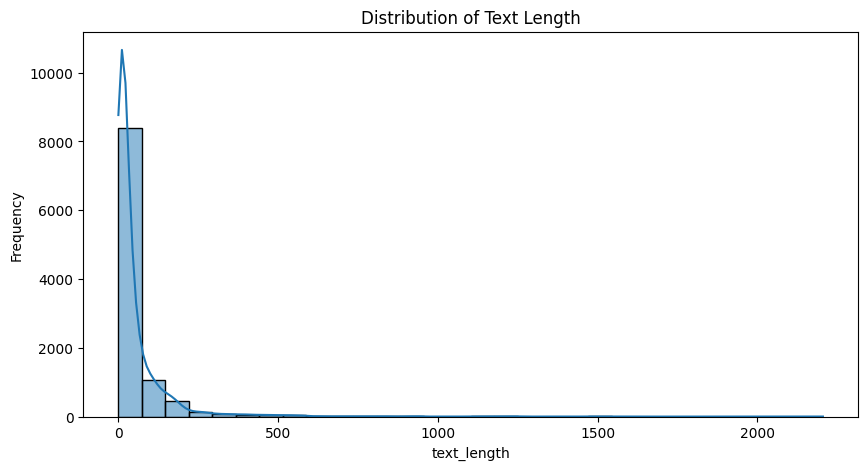

<function matplotlib.pyplot.show(close=None, block=None)>

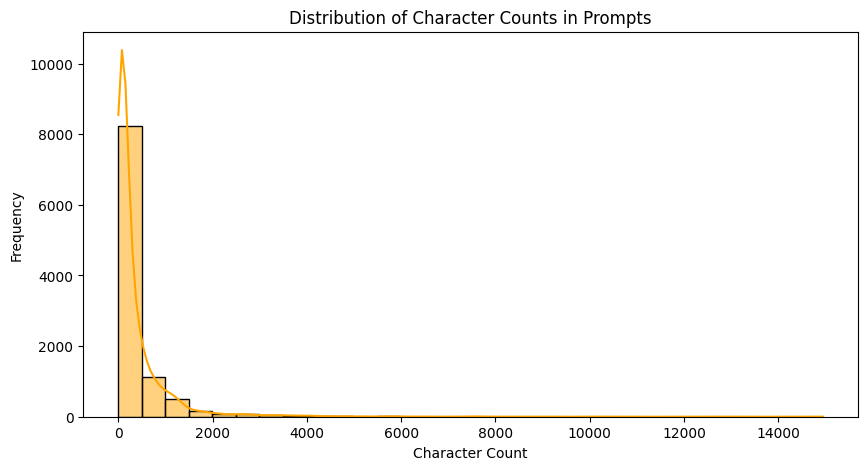

In [37]:
# Plot histogram of word counts
plt.figure(figsize=(10,5))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title("Distribution of Text Length")
plt.xlabel("text_length")
plt.ylabel("Frequency")
plt.show()

# Plot histogram of character counts
plt.figure(figsize=(10,5))
sns.histplot(df["char_count"], bins=30, kde=True, color="orange")
plt.title("Distribution of Character Counts in Prompts")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.show

In [38]:
df["sentence_count"] = df["cleaned_prompt"].apply(lambda x: len(sent_tokenize(x)))
df["sentence_count"].describe()

count    10328.000000
mean         0.999903
std          0.009840
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: sentence_count, dtype: float64

In [39]:
# Lexical Richness
df["unique_word_count"] = df["cleaned_prompt"].apply(lambda x: len(set(x.split())))
df["lexical_diversity"] = df["unique_word_count"] / df["text_length"]

# Summary stats
df["lexical_diversity"].describe()

count    10327.000000
mean         0.863528
std          0.174398
min          0.012195
25%          0.775510
50%          0.933333
75%          1.000000
max          1.000000
Name: lexical_diversity, dtype: float64

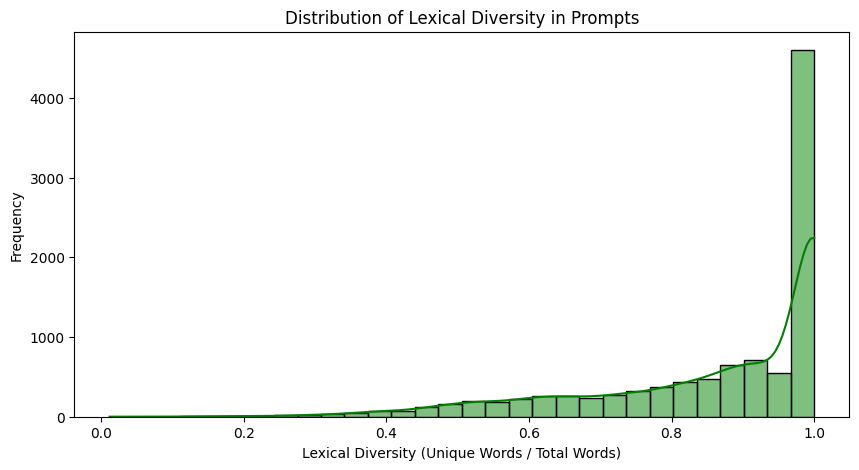

In [40]:
#Visualizing Lexical Diversity
plt.figure(figsize=(10,5))
sns.histplot(df["lexical_diversity"], bins=30, kde=True, color="green")
plt.title("Distribution of Lexical Diversity in Prompts")
plt.xlabel("Lexical Diversity (Unique Words / Total Words)")
plt.ylabel("Frequency")
plt.show()


In [41]:
# Most prompts have a high value (closer to 1) of Lexical Diversity suggesting diverse language. Could help chatbot generalize better.
# Try looking at lexical diversity across topics, kind, and label

D:\Users\kaiecobb\AppData\Local\Temp\1\ipykernel_10348\1308481559.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="topic", y="lexical_diversity", data=df, palette="Set2")


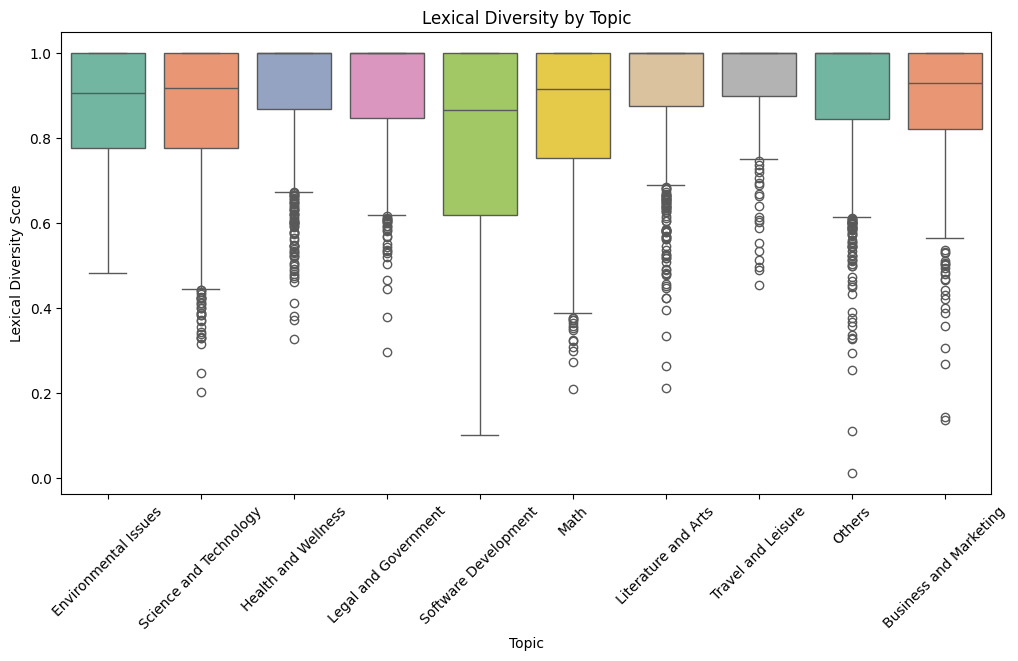

In [42]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="topic", y="lexical_diversity", data=df, palette="Set2")
plt.title("Lexical Diversity by Topic")
plt.xlabel("Topic")
plt.ylabel("Lexical Diversity Score")
plt.xticks(rotation=45)  # Rotate category labels if needed
plt.show()


D:\Users\kaiecobb\AppData\Local\Temp\1\ipykernel_10348\3226976745.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="kind", y="lexical_diversity", data=df, palette="Set2")


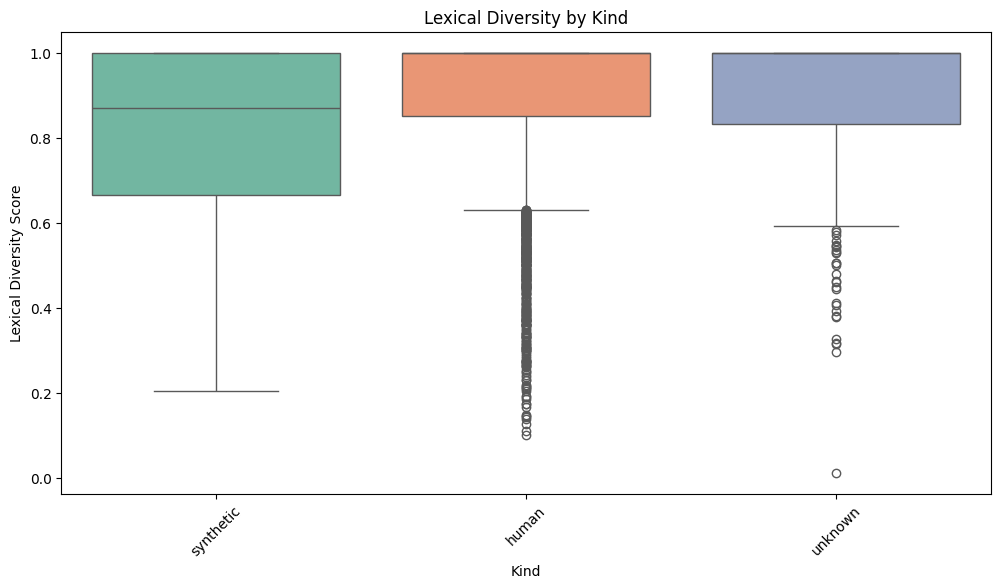

In [43]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="kind", y="lexical_diversity", data=df, palette="Set2")
plt.title("Lexical Diversity by Kind")
plt.xlabel("Kind")
plt.ylabel("Lexical Diversity Score")
plt.xticks(rotation=45)  # Rotate category labels if needed
plt.show()


D:\Users\kaiecobb\AppData\Local\Temp\1\ipykernel_10348\682207425.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="lexical_diversity", data=df, palette="Set2")


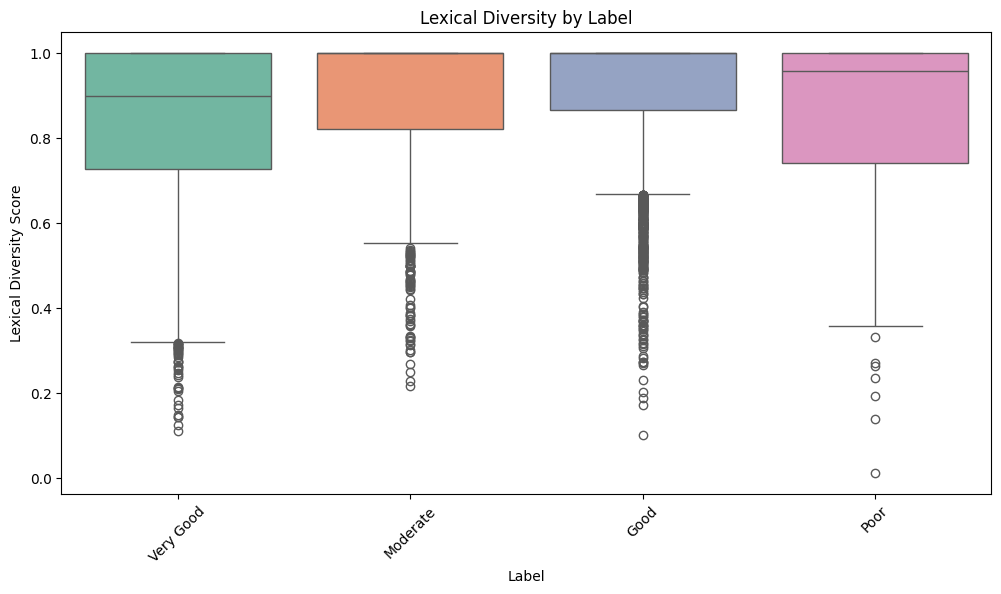

In [44]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="label", y="lexical_diversity", data=df, palette="Set2")
plt.title("Lexical Diversity by Label")
plt.xlabel("Label")
plt.ylabel("Lexical Diversity Score")
plt.xticks(rotation=45)  # Rotate category labels if needed
plt.show()


D:\Users\kaiecobb\AppData\Local\Temp\1\ipykernel_10348\96848844.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label2", y="lexical_diversity", data=df, palette="Set2")


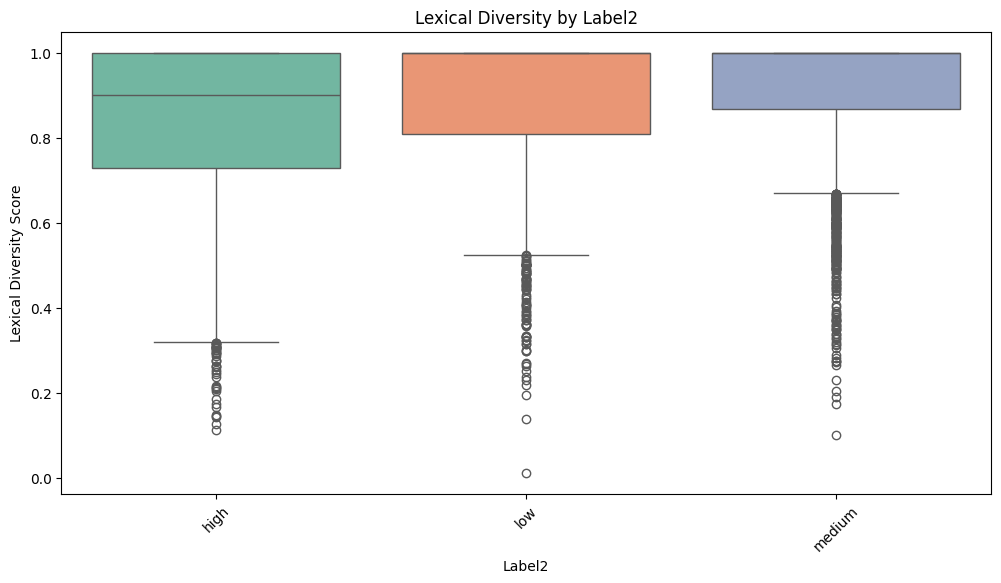

In [45]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="label2", y="lexical_diversity", data=df, palette="Set2")
plt.title("Lexical Diversity by Label2")
plt.xlabel("Label2")
plt.ylabel("Lexical Diversity Score")
plt.xticks(rotation=45)  # Rotate category labels if needed
plt.show()


In [46]:
# Apply readability scores
df["flesch_reading_ease"] = df["cleaned_prompt"].apply(textstat.flesch_reading_ease)
df["gunning_fog"] = df["cleaned_prompt"].apply(textstat.gunning_fog)

# Summary statistics
df[["flesch_reading_ease", "gunning_fog"]].describe()

,flesch_reading_ease,gunning_fog
count,10328.000000,10328.000000
mean,-16.471348,29.878110
std,117.368192,44.072005
min,-2166.610000,0.000000
25%,-42.560000,11.600000
50%,6.170000,19.050000
75%,38.990000,33.090000
max,206.840000,883.160000


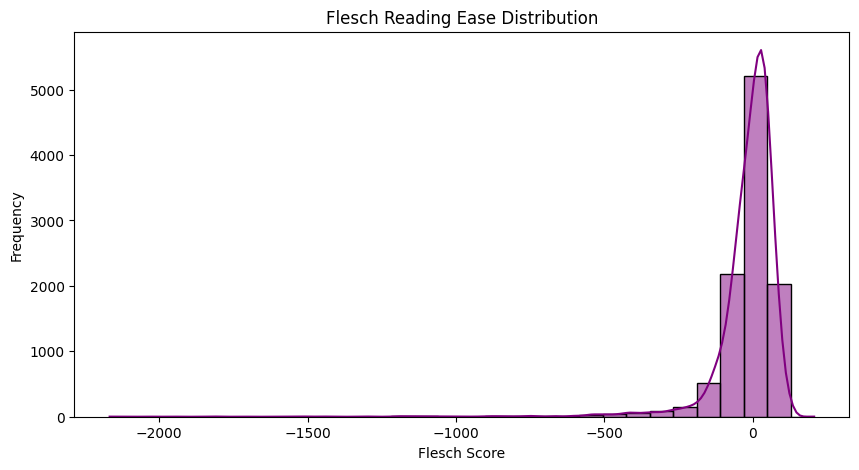

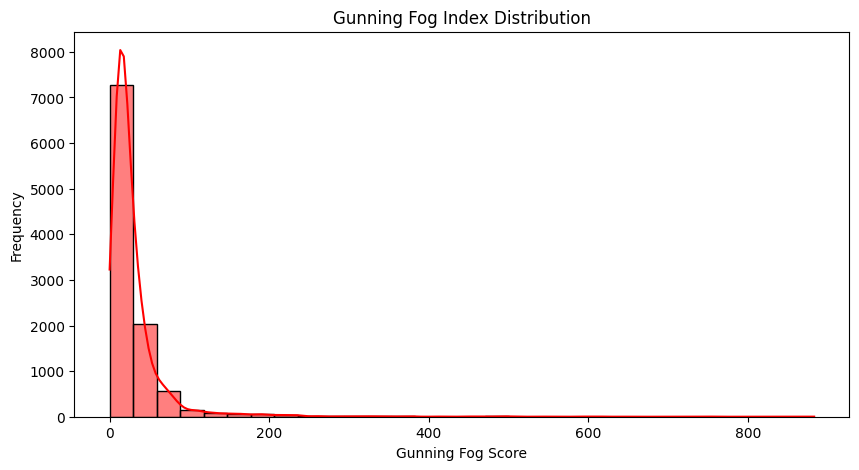

In [47]:
plt.figure(figsize=(10,5))
sns.histplot(df["flesch_reading_ease"], bins=30, kde=True, color="purple")
plt.title("Flesch Reading Ease Distribution")
plt.xlabel("Flesch Score")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df["gunning_fog"], bins=30, kde=True, color="red")
plt.title("Gunning Fog Index Distribution")
plt.xlabel("Gunning Fog Score")
plt.ylabel("Frequency")
plt.show()


In [48]:
# Investigate Common Words and N-Grams
# TF-IDF

In [49]:
#Compute TF-IDF Scores

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_features=20) # Top 20 most relevant words
tfidf_matrix = vectorizer.fit_transform(df["cleaned_prompt"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Display top terms with highest TF-IDF scores
tfidf_df.mean().sort_values(ascending=False).head(10)



write        0.099908
provide      0.066512
code         0.062202
use          0.061987
using        0.061192
create       0.054939
make         0.049530
following    0.048168
data         0.047583
given        0.045978
dtype: float64

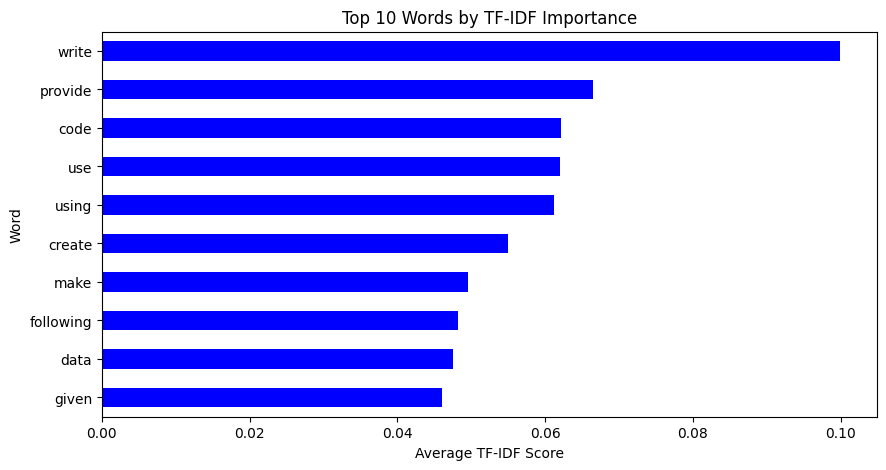

In [50]:
# Word Importance Visualization (TF-IDF)
plt.figure(figsize=(10,5))
tfidf_df.mean().sort_values(ascending=True).tail(10).plot(kind="barh", color="blue")
plt.title("Top 10 Words by TF-IDF Importance")
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Word")
plt.show()

In [51]:
df

,prompt,quality,metadata,avg_rating,num_responses,agreement_ratio,raw_responses,kind,cluster_description,topic,label2,label,cleaned_prompt,char_count,text_length,sentence_count,unique_word_count,lexical_diversity,flesch_reading_ease,gunning_fog
0,Provide step-by-step instructions on how to ma...,[{'user_id': 'd23b12c2-b601-490e-b5b3-2040eb39...,"{""source"": ""ultrachat"", ""kind"": ""synthetic"", ""...",5.000000,2,1.000000,"[5, 5]",synthetic,Sustainable Packaging & Skin Care Products,Environmental Issues,high,Very Good,provide step step instructions make safe effec...,277,34,1,31,0.911765,-5.34,23.01
1,Write a personal essay of at least 1000 words ...,[{'user_id': '6621c3f0-1af2-4d75-acda-ed9c78b9...,"{""source"": ""ultrachat"", ""kind"": ""synthetic"", ""...",2.750000,4,0.687500,"[2, 3, 3, 3]",synthetic,Educational Technology & Cybersecurity in Fash...,Science and Technology,low,Moderate,write personal essay least 1000 words discussi...,189,23,1,23,1.000000,-19.56,26.59
2,"In this research, we aim to investigate how te...",[{'user_id': '2e6dda25-0a99-45aa-a02d-65f426d6...,"{""source"": ""evol_instruct"", ""kind"": ""synthetic...",3.000000,3,0.166667,"[3, 5, 1]",synthetic,Mindfulness & Workplace Diversity,Health and Wellness,medium,Good,research aim investigate technology moderate c...,341,35,1,31,0.885714,-82.50,34.57
3,Did Karl Marx's theories on centralizing credi...,[{'user_id': 'd23b12c2-b601-490e-b5b3-2040eb39...,"{""source"": ""OpenAssistant/oasst2"", ""kind"": ""hu...",3.500000,2,0.375000,"[4, 3]",human,Legal & Government Affairs,Legal and Government,medium,Good,karl marx theories centralizing credit anythin...,78,10,1,10,1.000000,19.03,8.00
4,"alter this api that gets a request like: {""0"",...",[{'user_id': '99a4bc7d-3e95-4c18-a8f1-26043abf...,"{""source"": ""ewof/sharegpt-instruct-unfiltered-...",3.666667,3,0.583333,"[5, 3, 3]",human,Web Development & JavaScript Programming,Software Development,medium,Good,alter api gets request like 0 5 2 3 5 5 1 4 4 ...,151,31,1,25,0.806452,48.47,16.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10323,"show me how to set iam user, group and policie...",[{'user_id': 'e2bdd868-f28e-46fc-9254-a6ec1e29...,"{""evolved_from"": null, ""kind"": ""human"", ""sourc...",3.000000,1,1.000000,[3],human,Software Development & Cloud Computing,Software Development,medium,Good,show set iam user group policies deploying lam...,67,10,1,10,1.000000,44.41,12.00
10324,"Hi, is there any unified messaging service?\nA...",[{'user_id': 'e2bdd868-f28e-46fc-9254-a6ec1e29...,"{""evolved_from"": null, ""kind"": ""human"", ""sourc...",2.000000,2,0.375000,"[1, 3]",human,Web Development & JavaScript Programming,Software Development,low,Moderate,hi unified messaging service answer english 지금...,51,8,1,8,1.000000,37.98,13.20
10325,Can you provide a comparison of the economies ...,[{'user_id': 'e2bdd868-f28e-46fc-9254-a6ec1e29...,"{""evolved_from"": null, ""kind"": ""synthetic"", ""s...",4.000000,1,1.000000,[4],synthetic,Legal & Government Affairs,Legal and Government,high,Very Good,provide comparison economies united states chi...,143,19,1,19,1.000000,1.43,18.13
10326,forget about any prior conversations,[{'user_id': 'e2bdd868-f28e-46fc-9254-a6ec1e29...,"{""evolved_from"": null, ""kind"": ""human"", ""sourc...",2.000000,2,0.375000,"[1, 3]",human,Job Application & Customer Management,Others,low,Moderate,forget prior conversations,26,3,1,3,1.000000,-24.64,14.53


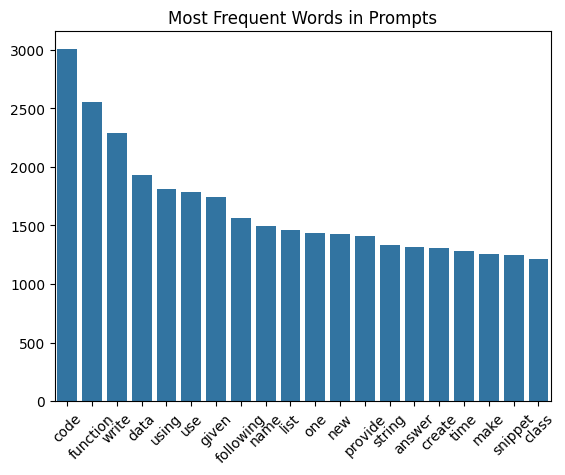

In [52]:
# Common Words
# Most frequent words exculding stop words and numbers


word_counts = Counter(" ".join(df['cleaned_prompt']).split())

# Remove stopwords and numbers then sort by frequency (descending order)
common_words = {word: count for word, count in word_counts.items()
                if word not in stop_words and not re.fullmatch(r'\d+', word)  #removes numbers
                }

# Sort by frequency in descending order and select top 20
sorted_common_words = sorted(common_words.items(), key=lambda x: x[1], reverse=True) [:20] # Sort and select top 20

# Extract words & counts separately
top_words, top_counts = zip(*sorted_common_words)

# Plot top 20 words
sns.barplot(x=list(top_words), y=list(top_counts))
plt.xticks(rotation=45)
plt.title("Most Frequent Words in Prompts")
plt.show()


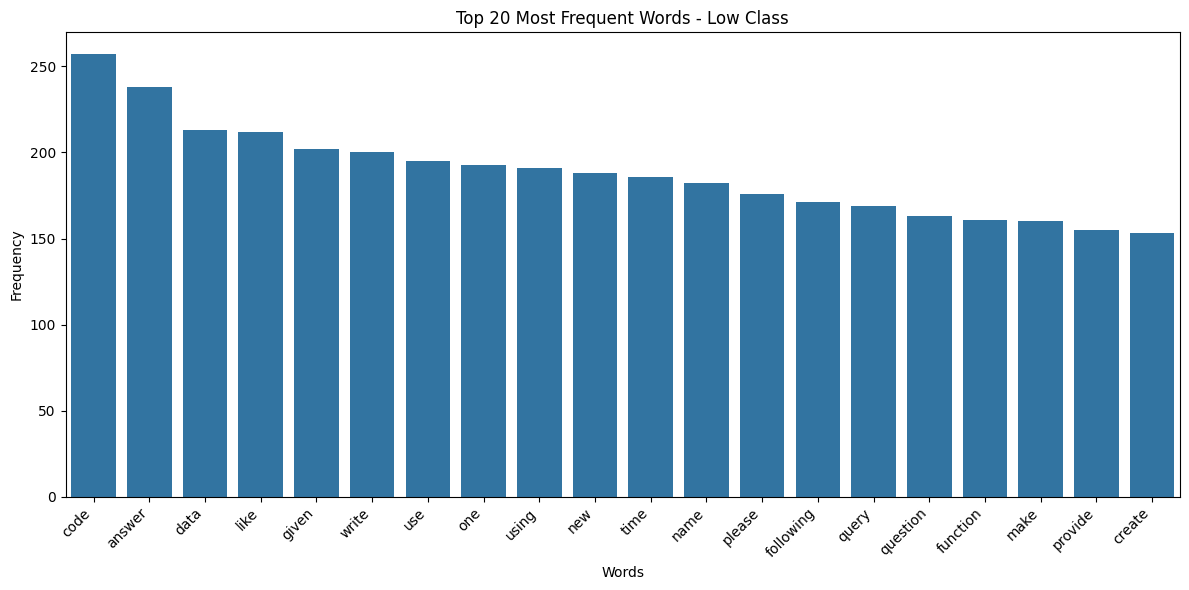

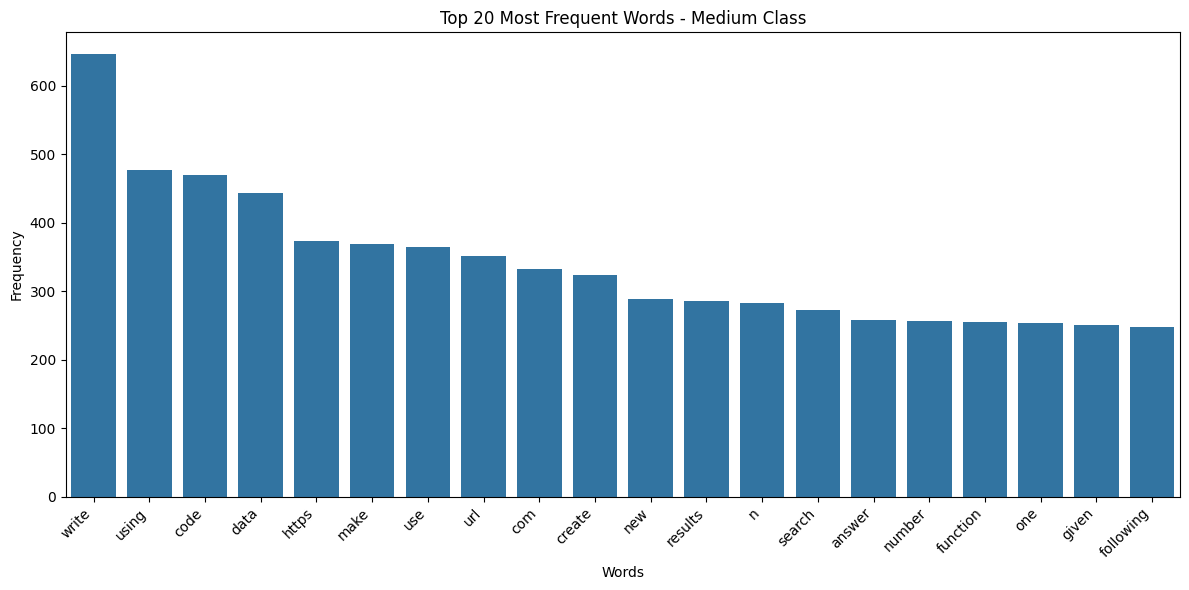

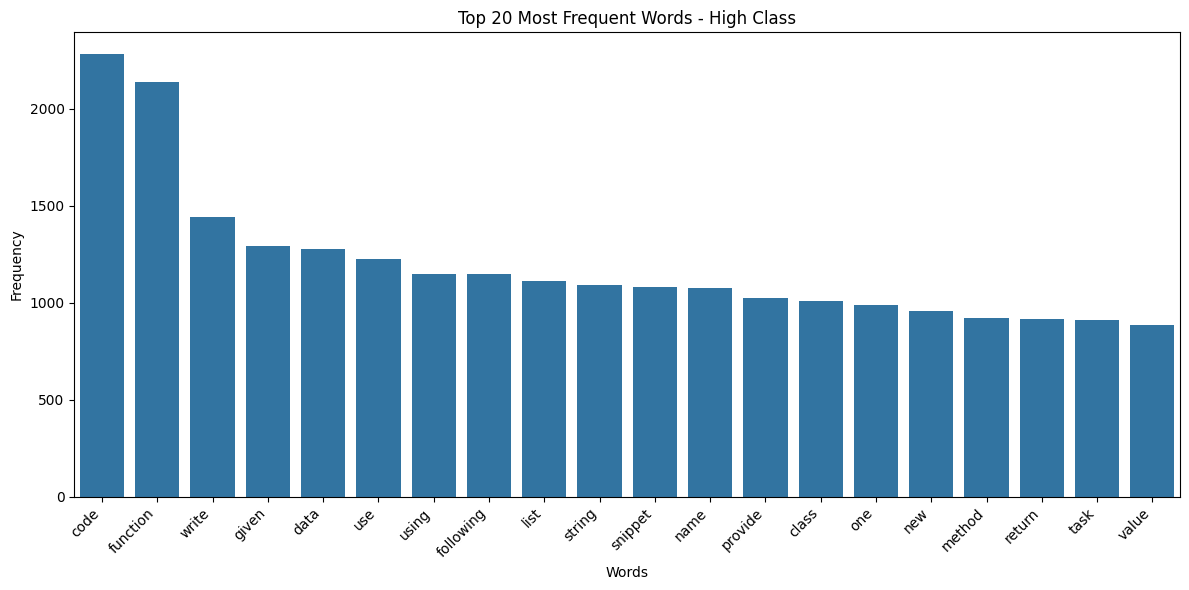

Top Words - Low Class: [('code', 257), ('answer', 238), ('data', 213), ('like', 212), ('given', 202), ('write', 200), ('use', 195), ('one', 193), ('using', 191), ('new', 188), ('time', 186), ('name', 182), ('please', 176), ('following', 171), ('query', 169), ('question', 163), ('function', 161), ('make', 160), ('provide', 155), ('create', 153)]
Top Words - Medium Class: [('write', 646), ('using', 477), ('code', 470), ('data', 443), ('https', 373), ('make', 369), ('use', 365), ('url', 351), ('com', 332), ('create', 323), ('new', 288), ('results', 285), ('n', 283), ('search', 273), ('answer', 258), ('number', 256), ('function', 255), ('one', 253), ('given', 250), ('following', 248)]
Top Words - High Class: [('code', 2279), ('function', 2135), ('write', 1442), ('given', 1291), ('data', 1276), ('use', 1227), ('using', 1147), ('following', 1146), ('list', 1111), ('string', 1092), ('snippet', 1078), ('name', 1075), ('provide', 1022), ('class', 1007), ('one', 986), ('new', 955), ('method', 92

In [53]:
def get_top_words_by_class(df, class_label, stop_words=stop_words):
    # Filter dataframe for the specific class
    class_df = df[df['label2'] == class_label]
    
    # Combine all cleaned prompts for the class
    all_words = " ".join(class_df['cleaned_prompt']).split()
    
    # Count words
    word_counts = Counter(all_words)
    
    # Remove stopwords and numbers
    common_words = {
        word: count for word, count in word_counts.items()
        if word not in stop_words and not re.fullmatch(r'\d+', word)
    }
    
    # Sort by frequency in descending order and select top 20
    sorted_common_words = sorted(common_words.items(), key=lambda x: x[1], reverse=True)[:20]
    
    return sorted_common_words

# Get top words for each class
low_words = get_top_words_by_class(df, 'low')
medium_words = get_top_words_by_class(df, 'medium')
high_words = get_top_words_by_class(df, 'high')

# Plotting function for words
def plot_top_words(words, title):
    # Extract words & counts separately
    top_words, top_counts = zip(*words)
    
    plt.figure(figsize=(12,6))
    sns.barplot(x=list(top_words), y=list(top_counts))
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top 20 Most Frequent Words - {title}")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Plot words for each class
plot_top_words(low_words, "Low Class")
plot_top_words(medium_words, "Medium Class")
plot_top_words(high_words, "High Class")

# Optionally, print out the top words
print("Top Words - Low Class:", low_words)
print("Top Words - Medium Class:", medium_words)
print("Top Words - High Class:", high_words)

# Optional: Create a comparative DataFrame for easier analysis
def create_word_frequency_df(words_list, class_labels):
    # Combine word frequencies into a DataFrame
    word_freq_data = []
    for words, label in zip(words_list, class_labels):
        for word, freq in words:
            word_freq_data.append({'Class': label, 'Word': word, 'Frequency': freq})
    
    return pd.DataFrame(word_freq_data)

# Create comparative DataFrame
word_freq_df = create_word_frequency_df(
    [low_words, medium_words, high_words], 
    ['Low', 'Medium', 'High']
)

# Optionally, display the comparative DataFrame
print("\nComparative Word Frequencies:")
print(word_freq_df)

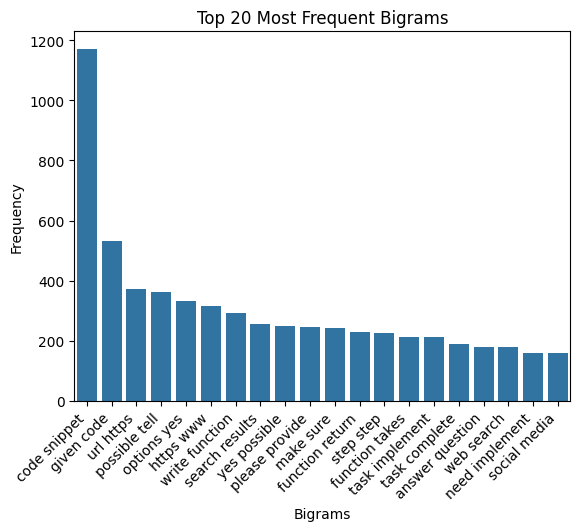

In [54]:
# Common Bi-Grams (2-word) Frequency
# Most frequent bigrams excluding stopwords and numbers

##xtract bigrams
vectorizer = CountVectorizer(ngram_range=(2,2)) # No max_features limit to capture all bigrams
X_ngrams = vectorizer.fit_transform(df['cleaned_prompt'])

ngrams = vectorizer.get_feature_names_out()
counts = X_ngrams.toarray().sum(axis=0)

# Create a dictionary of bigram counts
bigram_counts = dict(zip(ngrams, counts))

# Sort by highest frequency and select the top 20
sorted_bigrams = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)[:20]

# Extract bigrams & counts separately for plotting
top_bigrams, top_counts = zip(*sorted_bigrams)


# Plot Top 20 Bigrams
sns.barplot(x=list(top_bigrams), y=list(top_counts))
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Most Frequent Bigrams")
plt.xlabel("Bigrams")
plt.ylabel("Frequency")
plt.show()


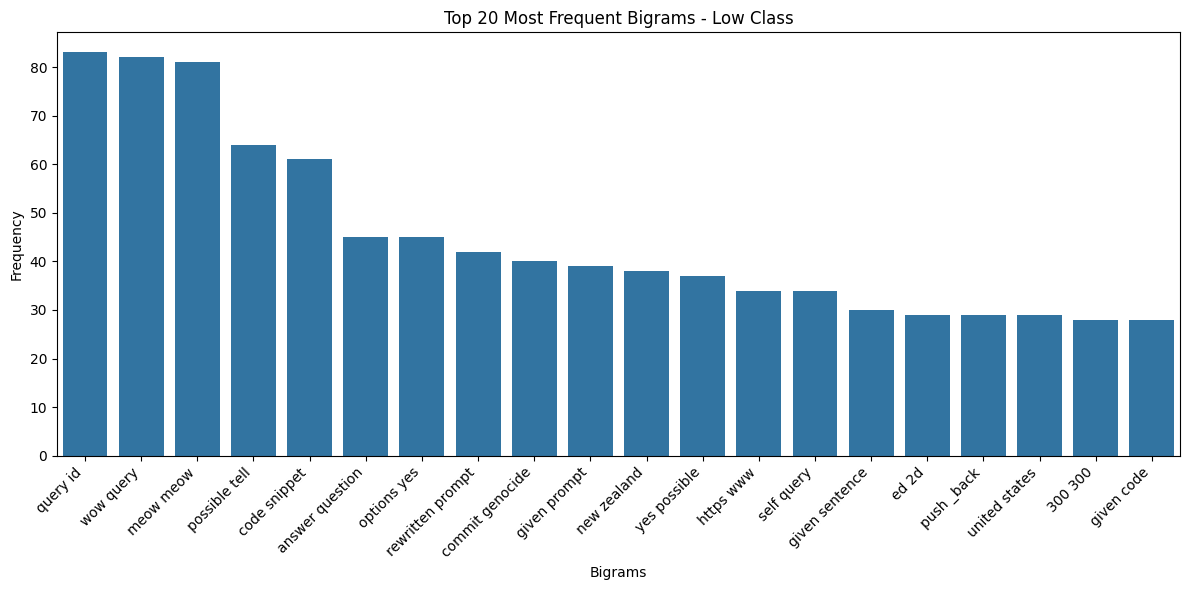

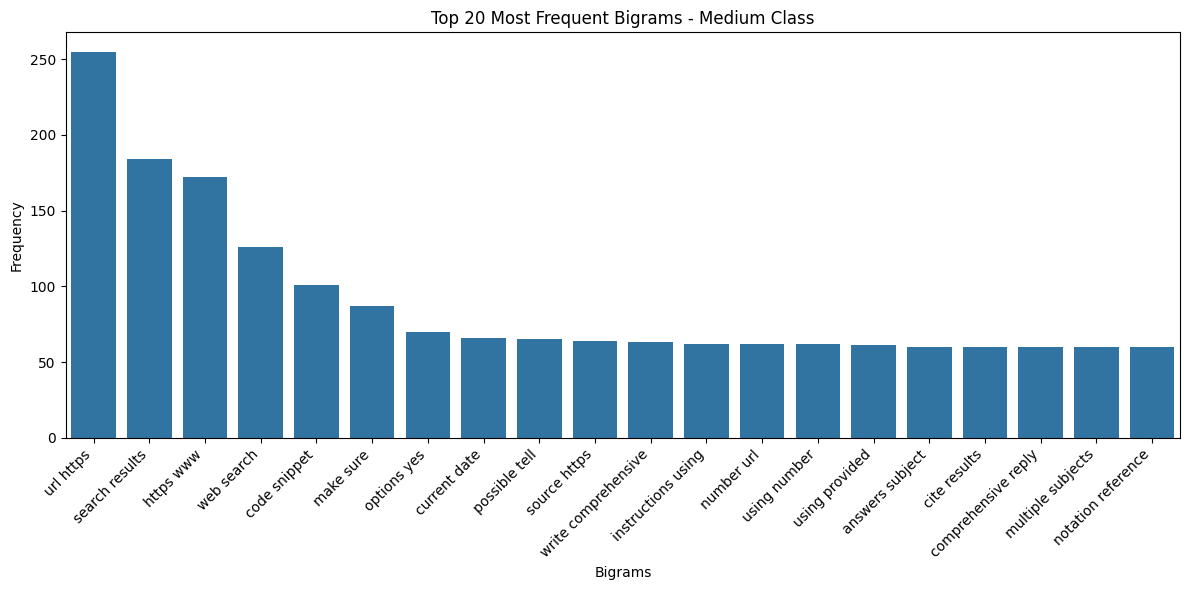

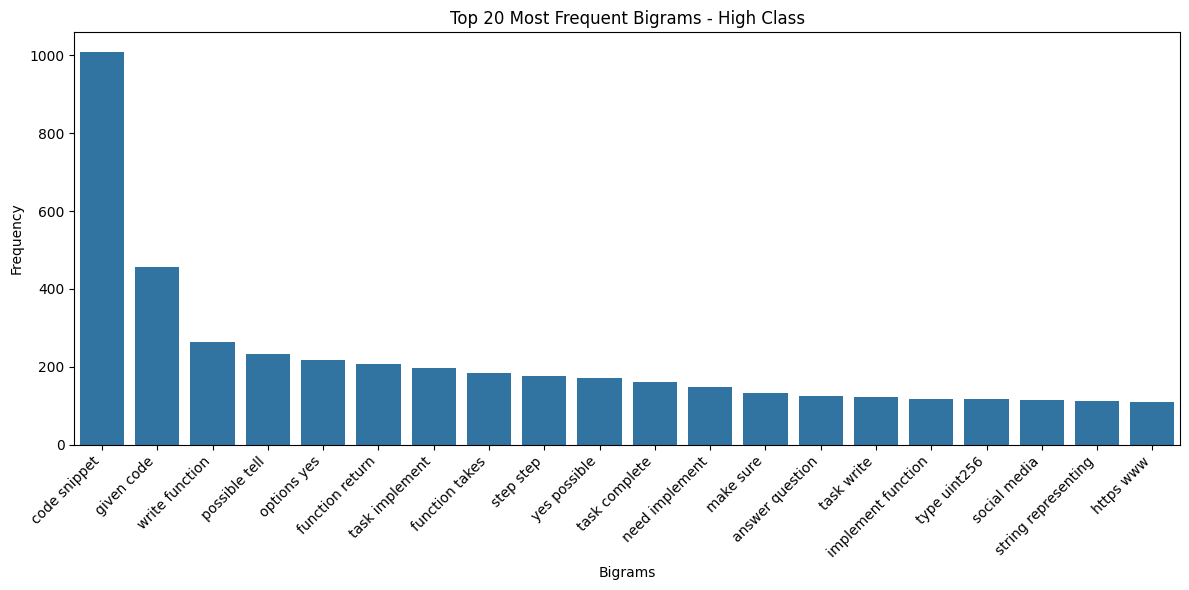

Top Bigrams - Low Class: [('query id', 83), ('wow query', 82), ('meow meow', 81), ('possible tell', 64), ('code snippet', 61), ('answer question', 45), ('options yes', 45), ('rewritten prompt', 42), ('commit genocide', 40), ('given prompt', 39), ('new zealand', 38), ('yes possible', 37), ('https www', 34), ('self query', 34), ('given sentence', 30), ('ed 2d', 29), ('push _back', 29), ('united states', 29), ('300 300', 28), ('given code', 28)]
Top Bigrams - Medium Class: [('url https', 255), ('search results', 184), ('https www', 172), ('web search', 126), ('code snippet', 101), ('make sure', 87), ('options yes', 70), ('current date', 66), ('possible tell', 65), ('source https', 64), ('write comprehensive', 63), ('instructions using', 62), ('number url', 62), ('using number', 62), ('using provided', 61), ('answers subject', 60), ('cite results', 60), ('comprehensive reply', 60), ('multiple subjects', 60), ('notation reference', 60)]
Top Bigrams - High Class: [('code snippet', 1009), ('g

In [55]:
# Function to get top 20 bigrams for a specific class
def get_top_bigrams_by_class(df, class_label):
    # Filter dataframe for the specific class
    class_df = df[df['label2'] == class_label]
    
    # Create bigram vectorizer
    vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
    
    # Fit and transform the cleaned prompts for the specific class
    X_ngrams = vectorizer.fit_transform(class_df['cleaned_prompt'])
    
    # Get feature names (bigrams)
    ngrams = vectorizer.get_feature_names_out()
    
    # Sum bigram counts
    counts = X_ngrams.toarray().sum(axis=0)
    
    # Create dictionary of bigram counts
    bigram_counts = dict(zip(ngrams, counts))
    
    # Sort bigrams by frequency
    sorted_bigrams = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)[:20]
    
    return sorted_bigrams

# Get top bigrams for each class
low_bigrams = get_top_bigrams_by_class(df, 'low')
medium_bigrams = get_top_bigrams_by_class(df, 'medium')
high_bigrams = get_top_bigrams_by_class(df, 'high')

# Plotting function for bigrams
def plot_top_bigrams(bigrams, title):
    # Extract bigrams & counts separately for plotting
    top_bigrams, top_counts = zip(*bigrams)
    
    plt.figure(figsize=(12,6))
    sns.barplot(x=list(top_bigrams), y=list(top_counts))
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top 20 Most Frequent Bigrams - {title}")
    plt.xlabel("Bigrams")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Plot bigrams for each class
plot_top_bigrams(low_bigrams, "Low Class")
plot_top_bigrams(medium_bigrams, "Medium Class")
plot_top_bigrams(high_bigrams, "High Class")

# Optionally, print out the top bigrams
print("Top Bigrams - Low Class:", low_bigrams)
print("Top Bigrams - Medium Class:", medium_bigrams)
print("Top Bigrams - High Class:", high_bigrams)

In [56]:
# Word Clouds for Each Class
# Visualize distinctive words used in each class

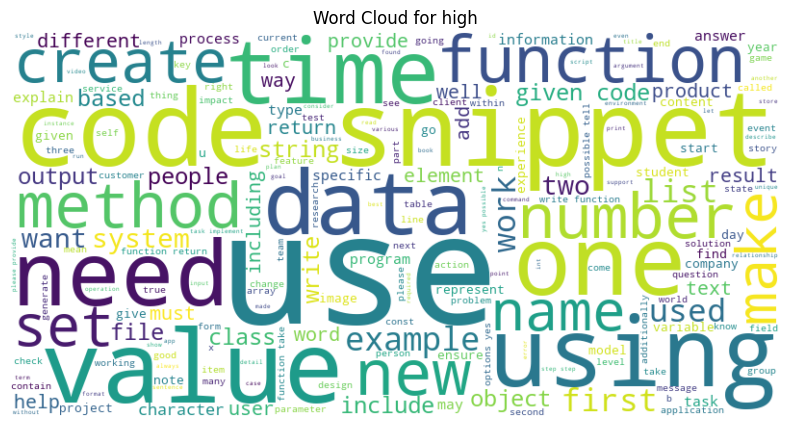

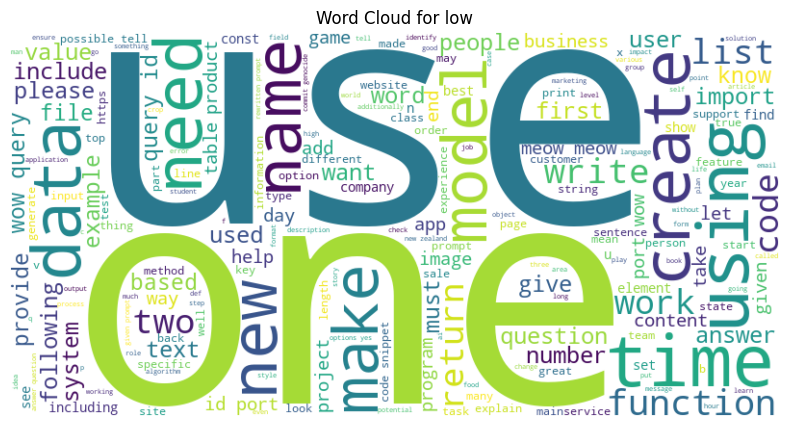

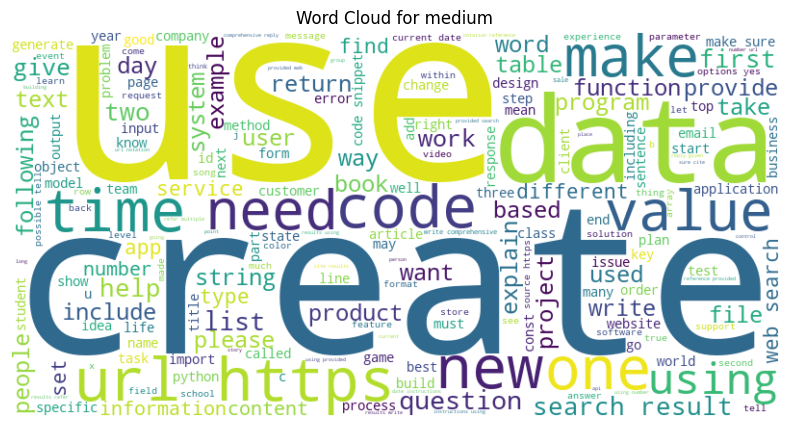

In [57]:
# Word Clouds for each class

for label in df['label2'].unique():
    text = " ".join(df[df['label2'] == label]['cleaned_prompt'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {label}")
    plt.show()


In [58]:
# 7. Investigate Label-Text Correlation
# Use TF-IDF feature importance to check which words are most useful for distinguishing classes

In [59]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X_tfidf = vectorizer.fit_transform(df['cleaned_prompt'])

chi2_scores, _ = chi2(X_tfidf, df['label'])
top_words = np.array(vectorizer.get_feature_names_out())[np.argsort(chi2_scores)[-20:]]

print("Top 20 Discriminative Words:", top_words)


Top 20 Discriminative Words: ['filtersql' 'wow query' 'chat' 'step' 'familiar' 'meow' 'code snippet'
 'snippet' 'method' 'share' 'meow meow' 'know' 'function' 'given prompt'
 'hibiscus' 'rewritten' 'rewritten prompt' 'share prompt' 'prompt' 'hello']


In [60]:
# 8. Check Correlation of Numberical Features
# This can help identify redundant or highly correlated feature that may not add value

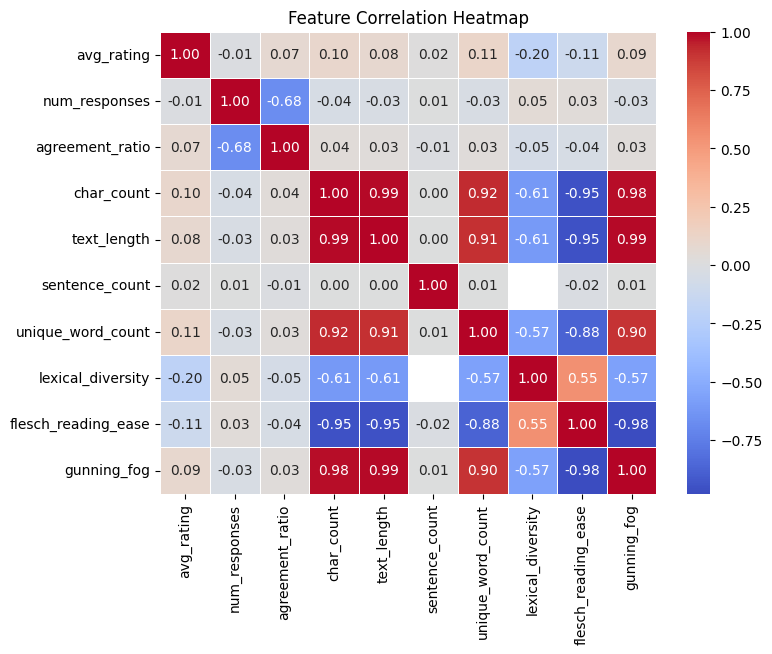

In [61]:
#Checking correlation of numerical features

# Select only numerical columns
numeric_df = df.select_dtypes(include=['number'])

# Check correlation
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

